In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, StratifiedShuffleSplit
from sklearn import metrics
import xgboost as xgb

### Импорт данных

In [2]:
train_df = pd.read_excel('/content/drive/MyDrive/sasha_test/2_model_binary.xlsx', sheet_name='Train', )
test_df = pd.read_excel('/content/drive/MyDrive/sasha_test/2_model_binary.xlsx', sheet_name='Test')

### Анализ категориальных переменных

In [3]:
def positive_proportion(train, column_name):
    """
    Function for calculating and vizualization doles 
    of positive samples for each category of discrete variables.

    """
    num = len(np.unique(np.array(train[column_name])))
    positive_samples = []
    
    for value in np.unique(np.array(train[column_name])):
        positive_samples.append(len(train[(train[column_name]==value) & (train['y']=='yes')]))
    
    all_samples = []
    for value in np.unique(np.array(train[column_name])):
        all_samples.append(len(train[(train[column_name]==value)]))

    positive_samples = np.array(positive_samples)
    all_samples = np.array(all_samples)
    props = positive_samples/all_samples
    
    plt.figure(figsize=(15,6))
    plt.title(column_name)
    plt.bar(np.arange(num), props, label = 'Yes', alpha=0.9, color='red')
    plt.bar(np.arange(num), [1]*num, label='No', alpha=0.3, color='blue')
    plt.legend()
    plt.xticks(np.arange(num), (np.unique(np.array(train[column_name]))))

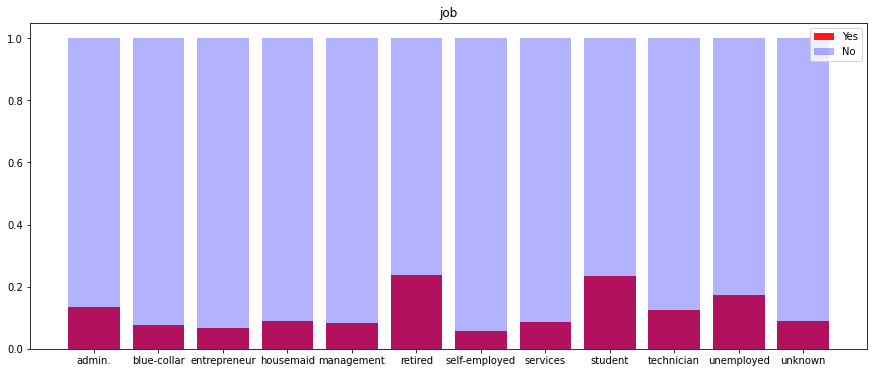

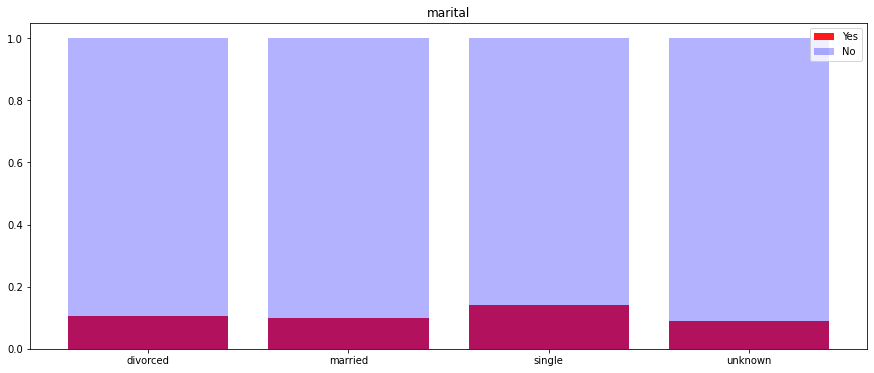

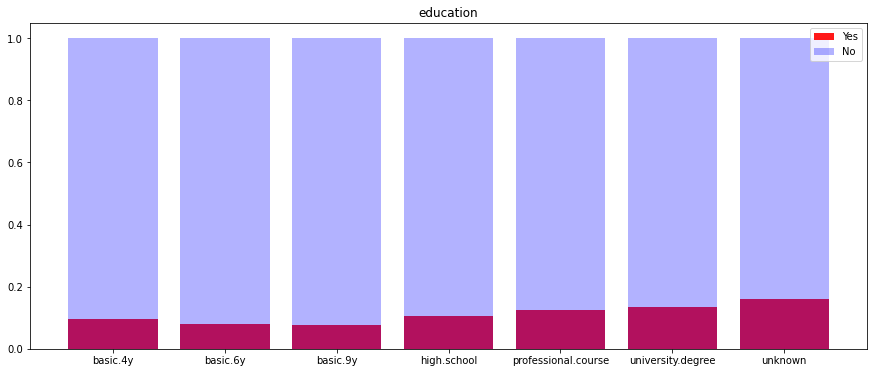

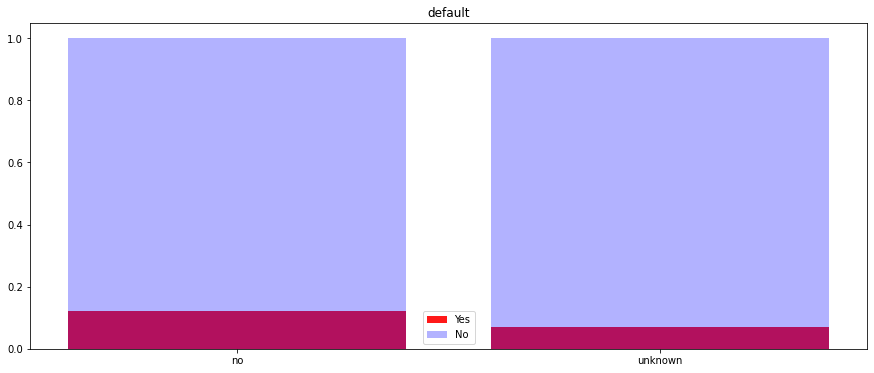

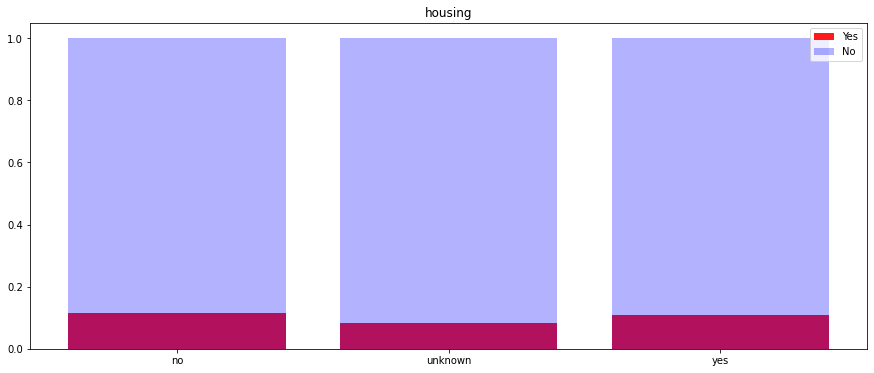

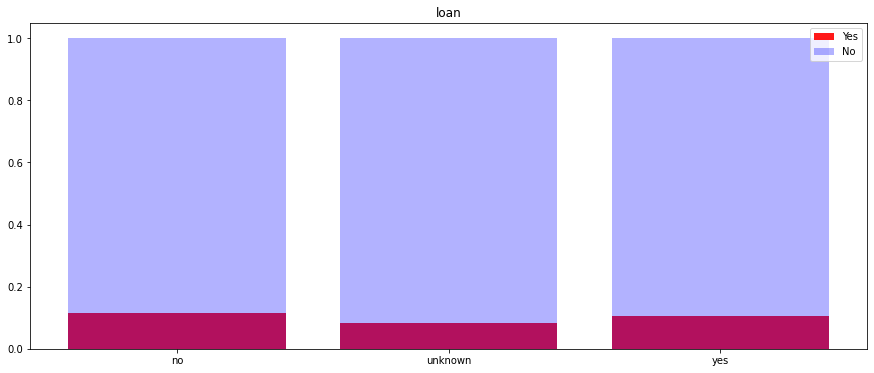

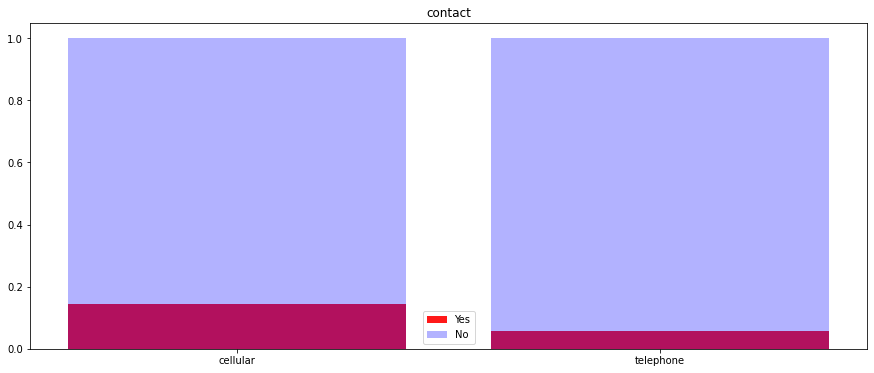

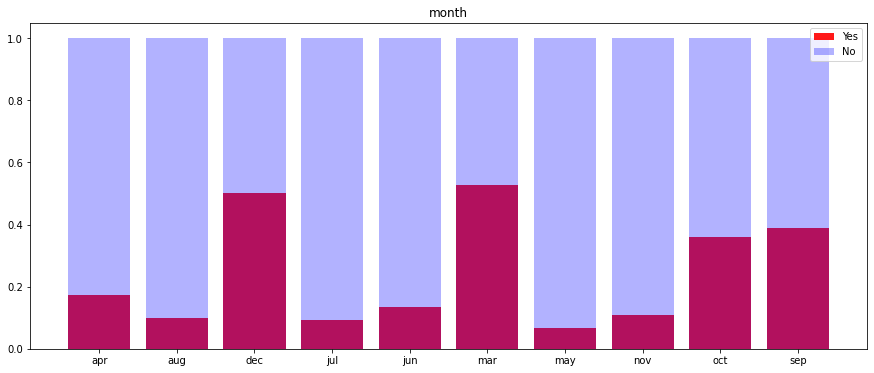

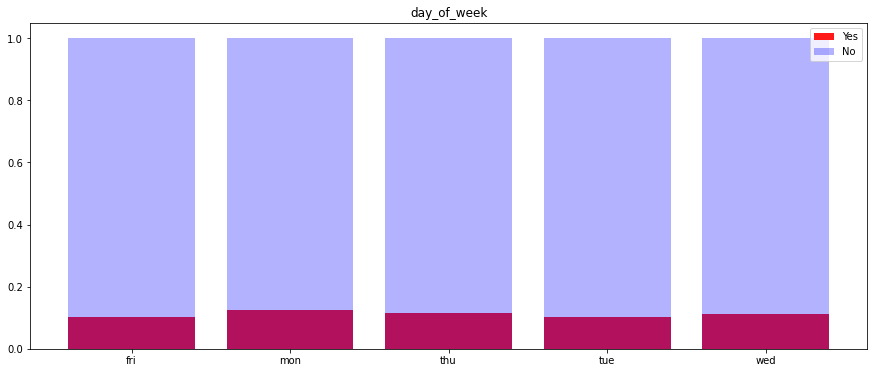

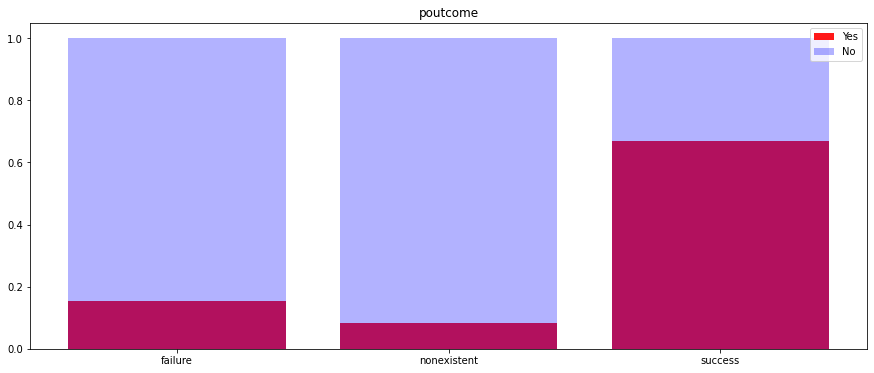

In [4]:
cat_features = ['job', 'marital', 'education', 'default', 
                'housing', 'loan', 'contact', 'month', 
                'day_of_week', 'poutcome']

for cat in cat_features:
    positive_proportion(train_df, cat)

В переменных 'poutcome', 'month', 'contact', 'job', 'education' заметно различаются доли положительных исходов по категориям, что может быть репрезентативно для классификатора. Произведем one-hot-encoding данных переменных. 

In [5]:
def one_hot_transform(train, cat_features):
  """
  Function for one-hot encoding of discrete variable
  """
  final_columns = []

  for feature in cat_features:
    for category in np.unique(np.array(train[feature])):
      train[category] = np.array([0]*len(train))
      final_columns.append(category)

    for i in range(len(train)):
      train[train[feature][i]][i] = 1
    
  return train[final_columns]

In [6]:
cat_features = ['poutcome', 'month', 'contact', 'job']
train_one_hot = one_hot_transform(train_df.copy(), cat_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Анализ непрерывных переменных

In [7]:
def cont_vars(data, vars):
  """
  Function for vizualization of variables distribution for targets 0 and 1 by boxplot
  """
  for var in vars:
    plt.figure(figsize=(5,4))
    plt.title('Disctribution for {} with target 0 and 1'.format(var))
    sns.boxplot(x="y", y=var, data=data)

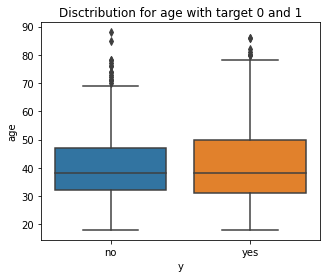

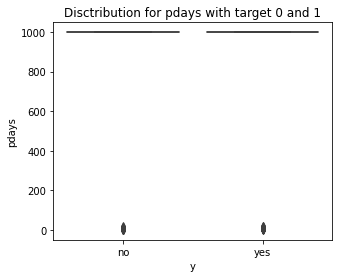

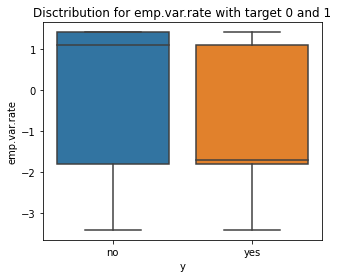

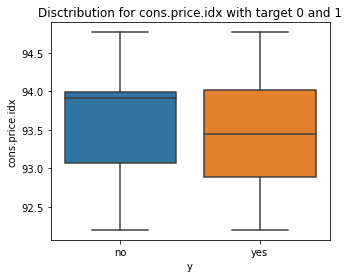

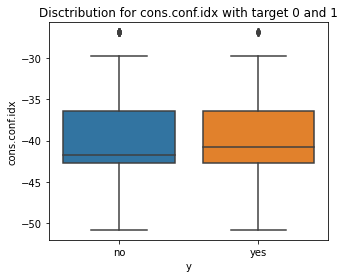

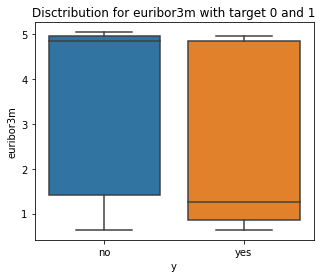

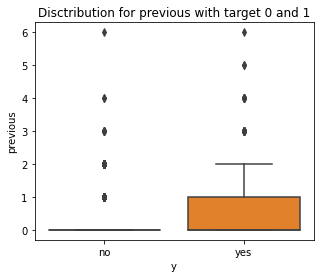

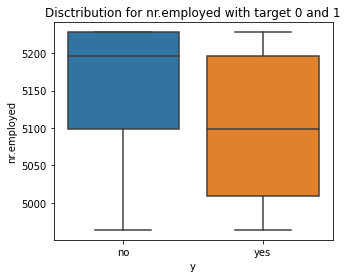

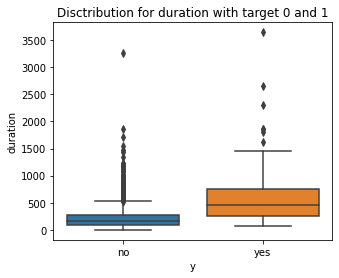

In [8]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
cont_vars(train_df, ['age', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                     'euribor3m','previous', 'nr.employed', 'duration'])

В переменных 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration' заметны различия медианы и/или межквартильного размаха. Такие переменные могут быть репрезентативными признаками.  

#### Анализ корреляции репрезентативных переменных

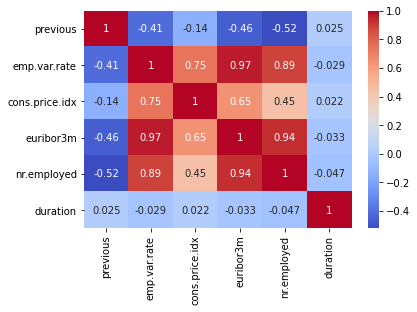

In [9]:
representative = ['previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration'] 
corr = train_df[representative].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

Заметна сильная корреляция для переменных 'emp.var.rate', 'euribor3m'. Такая корреляция может отрицательно повлиять на качество классификации. Построим корреляционную карту без данных переменных.

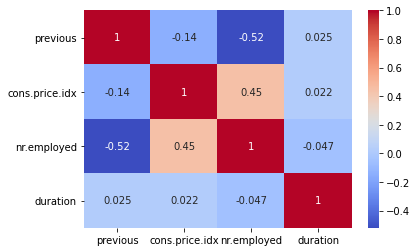

In [10]:
representative = ['previous', 'cons.price.idx', 'nr.employed', 'duration'] 
corr = train_df[representative].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

Теперь сильная корреляция между переменными не наблюдается. 

### Обучение и валидация случайного леса

In [11]:
train_data = pd.concat((train_one_hot, train_df[representative]), axis=1)
train_labels = [1 if y == 'yes' else 0 for y in train_df['y']]
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, 
                                                      test_size = 0.2, random_state=42)

In [12]:
classifier = RandomForestClassifier(random_state=20)

classifier.fit(X_train , y_train)
y_pred = classifier.predict(X_valid)
proba_pred = classifier.predict_proba(X_valid)[:, 1]

roc_auc = metrics.roc_auc_score(y_valid, proba_pred)
acc = metrics.accuracy_score(y_valid, y_pred)
f1 = metrics.f1_score(y_valid, y_pred)

print("Accuracy: ", round(acc, 3))
print("F1: ", round(f1, 3))
print("ROC_AUC: ", round(roc_auc, 3))

Accuracy:  0.898
F1:  0.515
ROC_AUC:  0.89


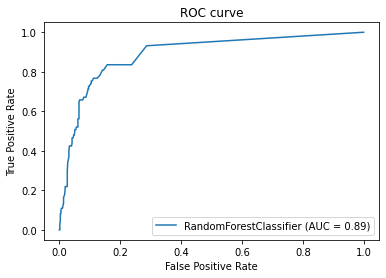

In [13]:
metrics.plot_roc_curve(classifier, X_valid, y_valid)
plt.title('ROC curve')   
plt.show()

### XGBClassifier

In [14]:
model = xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
proba_pred = model.predict_proba(X_valid)[:, 1]

roc_auc = metrics.roc_auc_score(y_valid, proba_pred)
acc = metrics.accuracy_score(y_valid, y_pred)
f1 = metrics.f1_score(y_valid, y_pred)

print("Accuracy: ", round(acc, 3))
print("F1: ", round(f1, 3))
print("ROC_AUC: ", round(roc_auc, 3))

Accuracy:  0.899
F1:  0.488
ROC_AUC:  0.922


В данных присутствует значительное преобладание отрицательных семплов, что отражается в высоком значении для accuracy и низком для F1.

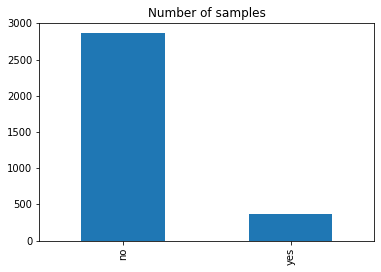

In [15]:
train_df['y'].value_counts().plot(kind='bar', title='Number of samples')

Сделаем oversampling для балансировки классов.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


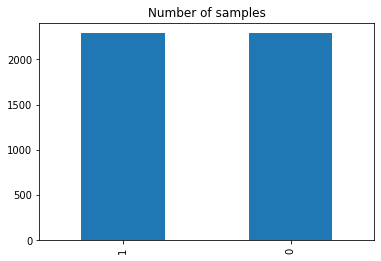

In [16]:
from imblearn.over_sampling import RandomOverSampler
simplefilter(action='ignore', category=FutureWarning)

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

X_train_over = pd.DataFrame(X_ros)
y_train_over = pd.DataFrame(y_ros)
X_train_over.columns = X_valid.columns

y_train_over[0].value_counts().plot(kind='bar', title='Number of samples');

Обучение XGBClassifier oversampling'а

In [17]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=20, random_state=20)
model.fit(X_train_over, y_train_over[0])
y_pred = model.predict(X_valid)
proba_pred = model.predict_proba(X_valid)[:, 1]

roc_auc = metrics.roc_auc_score(y_valid, proba_pred)
acc = metrics.accuracy_score(y_valid, y_pred)
f1 = metrics.f1_score(y_valid, y_pred)

print("Accuracy: ", round(acc, 3))
print("F1: ", round(f1, 3))
print("ROC_AUC: ", round(roc_auc, 3))

Accuracy:  0.86
F1:  0.559
ROC_AUC:  0.915


Метрика F1 для XGBClassifier, обученного на отбалансированном датасете выше, чем для XGBClassifier, обученного на стандартном датасете и лучше, чем F1 достигнутая RanfomForestClassifier.

ROC AUC снизилась на 0.07 относительно стандартного XGBClassifier. 

### Результаты на валидационное выборке

* Accuracy:  0.86
* F1:  0.559
* ROC_AUC:  0.915

## Предсказание для тестовой выборки

В качестве классификатора выберем XGBClassifier, обученный на датасете после oversampling'а.

In [ ]:
test_one_hot = one_hot_transform(test_df.copy(), cat_features)
test_data = pd.concat((test_one_hot, test_df[representative]), axis=1)
test_labels = [1 if y == 'yes' else 0 for y in train_df['y']]

y_pred = model.predict(test_data)

In [19]:
result_df = pd.DataFrame()
result_df['y'] = ['yes' if label == 1 else 'no' for label in y_pred]
result_df.to_excel('/content/drive/MyDrive/sasha_test/task2_result.xlsx', index=False)

In [20]:
result_df['y'].value_counts()

no     693
yes    204
Name: y, dtype: int64

Результат для тестовой выборки сохранен в столбец 'y' файла task2_result.xlsx